# Imports

In [2]:
import sys
import pandas as pd 
import numpy as np
import joblib

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold
import xgboost as xgb

import evaluationutils

# from dask import dataframe as dd
# from sklearn.manifold import MDS

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/raid/shared/whryniewska/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Configurations

In [3]:
params = {
    "reference": "./data/B2000_valid_only_eng.csv",
    "siamese": "./data/Siamese_Network_PadChest_B2000_deit.csv",
    "radiomic": "./data/radiomic_features.csv",
    "dino": "./data/dino_mds.csv",
}

# Reference file with labels

In [4]:
df_reference = pd.read_csv(params["reference"], sep = ';', converters={"labels": lambda x: x.strip("[]' ,").replace("'","").split(", ")})
df_reference.drop(columns=['patient_id', 'sex', 'age', 'projection', 'category'], inplace=True)
df_reference

,path,labels
0,10001.png,[Normal]
1,10002.png,[Normal]
2,10003.png,[Normal]
3,10004.png,[Normal]
4,10005.png,[Normal]
...,...,...
2152,50496.png,"[Nodule/pulmonary nodule, Pleural thickening]"
2153,50497.png,[Nodule/pulmonary nodule]
2154,50498.png,"[Parenchymal opacification, Nodular pattern, R..."
2155,50499.png,"[Nodular pattern, Nodule/pulmonary nodule, Loc..."


In [5]:
mlb = MultiLabelBinarizer(sparse_output=True)

y = df_reference.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df_reference['labels']),
                index=df_reference.index,
                columns=mlb.classes_).add_prefix('class_'))

y.drop(columns=['labels'], inplace=True)
y.head()

,path,class_Atelectasis,class_Band-like opacifications,class_Bleb,class_Bronchial wall thickening,class_Bronchiectasis,class_Bulla,class_Calcification,class_Cavity,class_Chest wall subcutaneous emphysema,...,class_Parenchymal opacification,class_Pleural effusion,class_Pleural thickening,class_Pneumomediastinum,class_Pneumopericardium,class_Pneumoperitoneum,class_Pneumothorax,class_Pulmonary hypertension,class_Reticonodular pattern,class_Reticular pattern
0,10001.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10002.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10003.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10004.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10005.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Other data

In [6]:
df_age = pd.read_csv(params["reference"], sep = ';')
# possibility to add sex
df_age.drop(columns=['patient_id', 'sex', 'projection', 'labels', 'category'], inplace=True)

df_age

,path,age
0,10001.png,1.0
1,10002.png,4.0
2,10003.png,11.0
3,10004.png,0.0
4,10005.png,2.0
...,...,...
2152,50496.png,43.0
2153,50497.png,32.0
2154,50498.png,38.0
2155,50499.png,41.0


In [8]:
df_radiomic = pd.read_csv(params["radiomic"], sep = ',')
df_radiomic.columns=df_radiomic.columns.map(lambda x : x+'radiomic' if x !='path' else x)
df_radiomic

,path,diagnostics_Image-original_Meanradiomic,diagnostics_Image-original_Minimumradiomic,diagnostics_Image-original_Maximumradiomic,diagnostics_Mask-original_VoxelNumradiomic,diagnostics_Mask-original_VolumeNumradiomic,original_shape_Elongationradiomic,original_shape_MajorAxisLengthradiomic,original_shape_Maximum2DDiameterColumnradiomic,original_shape_Maximum2DDiameterRowradiomic,...,diagnostics_Mask-original_CenterOfMassIndex_1radiomic,diagnostics_Mask-original_CenterOfMass_0radiomic,diagnostics_Mask-original_CenterOfMass_1radiomic,diagnostics_Image-original_Size_0radiomic,diagnostics_Image-original_Size_1radiomic,diagnostics_Image-original_Size_2radiomic,diagnostics_Mask-original_Spacing_0radiomic,diagnostics_Mask-original_Spacing_1radiomic,diagnostics_Mask-original_Size_0radiomic,diagnostics_Mask-original_Size_1radiomic
0,10001.png,3643.730799,0.0,16383.0,146995,4,0.489928,171.803021,140.9372,124.4544,...,449.692194,95.386521,83.282994,1093,933,1,0.1852,0.1852,1093,933
1,10002.png,5020.519682,0.0,16383.0,371548,4,0.646898,231.432628,184.4808,126.2736,...,473.640316,128.721183,89.802204,1305,1137,1,0.1896,0.1896,1305,1137
2,10003.png,1788.379015,1.0,4082.0,1497820,3,0.720892,313.900836,253.6720,197.4320,...,951.722451,167.579316,140.854923,2278,2061,1,0.1480,0.1480,2278,2061
3,10004.png,5606.361342,0.0,16383.0,136861,5,0.586460,153.657134,138.7148,68.8944,...,365.727687,94.583378,67.732768,1014,801,1,0.1852,0.1852,1014,801
4,10005.png,2806.019062,0.0,16383.0,228130,2,0.523663,207.943838,163.3464,89.0812,...,447.498422,97.495622,82.876708,1057,946,1,0.1852,0.1852,1057,946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2064,50482.png,566.375375,0.0,1023.0,1873074,2,0.762894,328.755683,259.8310,231.9460,...,1086.864444,155.905923,155.421616,2244,2652,1,0.1430,0.1430,2244,2652
2065,50483.png,545.424717,0.0,1023.0,1848472,2,0.677131,349.154369,285.1420,200.0570,...,1103.668330,205.968190,157.824571,2997,2797,1,0.1430,0.1430,2997,2797
2066,50484.png,612.332757,0.0,1023.0,2143555,2,0.618238,406.744610,341.3410,219.5050,...,1217.310802,197.860223,174.075445,2822,2977,1,0.1430,0.1430,2822,2977
2067,50485.png,543.799692,0.0,1023.0,1790211,4,0.648517,339.546090,272.9870,228.6570,...,1094.840549,203.279836,156.562199,3000,2961,1,0.1430,0.1430,3000,2961


In [10]:
df_siamese = pd.read_csv(params["siamese"], sep = ',')
df_siamese.drop(columns=['patient_id', 'age', 'projection', 'labels', 'category'], inplace=True, errors='ignore')
df_siamese.columns=df_siamese.columns.map(lambda x : x+'_siamese' if x !='path' else x)
df_siamese

,path,0_siamese,1_siamese,2_siamese,3_siamese,4_siamese,5_siamese,6_siamese,7_siamese,8_siamese,...,528_siamese,529_siamese,530_siamese,531_siamese,532_siamese,533_siamese,534_siamese,535_siamese,536_siamese,537_siamese
0,10001.png,-0.642082,-1.698861,-0.937482,0.079463,1.323823,0.774863,-0.854962,-0.619600,1.746192,...,0.000515,0.000526,0.000512,0.000511,0.000582,0.000551,0.000559,0.000631,0.00052,0.000519
1,10002.png,-0.652625,-1.823605,-1.037590,0.072400,1.476669,0.709906,-0.867819,-0.629906,1.765748,...,0.000515,0.000526,0.000512,0.000511,0.000582,0.000551,0.000559,0.000631,0.00052,0.000519
2,10003.png,-0.613711,-1.688153,-1.041999,0.037596,1.352383,0.693521,-0.818329,-0.591480,1.675942,...,0.000515,0.000526,0.000512,0.000511,0.000582,0.000551,0.000559,0.000631,0.00052,0.000519
3,10004.png,-0.641075,-1.822179,-1.107091,0.056384,1.569500,0.552255,-0.853497,-0.619564,1.735659,...,0.000515,0.000526,0.000512,0.000511,0.000582,0.000551,0.000559,0.000631,0.00052,0.000519
4,10005.png,-0.624487,-1.760837,-1.117727,0.032270,1.514843,0.547168,-0.833157,-0.602835,1.702769,...,0.000515,0.000526,0.000512,0.000511,0.000582,0.000551,0.000559,0.000631,0.00052,0.000519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2152,50496.png,-0.618943,-1.636037,-1.025706,0.036822,1.329794,0.666451,-0.825332,-0.597048,1.690028,...,0.000515,0.000526,0.000512,0.000511,0.000582,0.000551,0.000559,0.000631,0.00052,0.000519
2153,50497.png,-0.599464,-1.616668,-1.088144,0.007199,1.325176,0.638541,-0.800276,-0.578517,1.641694,...,0.000515,0.000526,0.000512,0.000511,0.000582,0.000551,0.000559,0.000631,0.00052,0.000519
2154,50498.png,-0.631688,-1.651170,-1.006321,0.048667,1.332736,0.692178,-0.841569,-0.609528,1.720105,...,0.000515,0.000526,0.000512,0.000511,0.000582,0.000551,0.000559,0.000631,0.00052,0.000519
2155,50499.png,-0.613355,-1.660426,-1.151653,-0.010575,1.292658,0.745016,-0.816624,-0.590250,1.671941,...,0.000515,0.000526,0.000512,0.000511,0.000582,0.000551,0.000559,0.000631,0.00052,0.000519


In [16]:
# Load DINO embeddings after MDS reduction
df_dino = pd.read_csv(params["dino"], sep = ',')
df_dino.columns=df_dino.columns.map(lambda x : x+'_dino' if x !='path' else x)
df_dino

,path,0_dino,1_dino,2_dino,3_dino,4_dino,5_dino,6_dino,7_dino,8_dino,...,374_dino,375_dino,376_dino,377_dino,378_dino,379_dino,380_dino,381_dino,382_dino,383_dino
0,10001.png,0.385496,-0.255915,-0.582963,-0.143908,-0.813406,0.398139,-0.586945,1.110767,0.214646,...,0.699301,0.400513,-0.537951,1.345703,-0.731893,0.750120,0.457651,-0.319925,0.155251,1.173112
1,10002.png,0.559166,-0.498929,-0.215761,-0.459626,-0.496707,0.206807,-0.416337,0.223457,-0.420604,...,0.348561,-0.058552,-0.354948,0.635096,-0.620827,0.113419,0.373366,-0.477964,-0.272466,0.317764
2,10003.png,0.214696,0.345066,-0.401355,0.295215,-0.033365,0.022878,-0.387926,0.154460,-0.336222,...,-0.140343,0.574171,0.342759,-0.399581,-0.493995,0.294906,-0.058334,-0.293319,-0.374383,-0.327923
3,10004.png,0.006871,-0.618338,-0.176816,-0.383818,-0.315611,-0.017351,-0.069838,0.685523,-0.624300,...,0.025099,0.440743,-0.588514,-0.151531,-0.338453,0.598840,0.333746,0.331985,-0.463665,0.300295
4,10005.png,0.729378,-0.620489,-0.253102,-0.212059,-0.551497,0.091771,-0.181353,1.076836,-0.156072,...,0.778939,0.771048,-0.789289,1.026133,-1.005531,1.328076,-0.009918,0.142177,-0.391294,0.960261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2153,50496.png,-0.210351,0.337502,0.028212,-0.082192,0.147870,-0.160746,0.161431,0.142569,-0.475093,...,-0.361451,-0.125164,0.126007,-0.336207,-0.156985,-0.377947,-0.281479,-0.161011,-0.073806,-0.424578
2154,50497.png,-0.442768,0.485159,-0.104074,0.322657,0.762358,-0.013917,-0.360937,-0.137851,-0.274686,...,-0.321646,0.515825,0.008563,-0.459375,-0.228114,0.252573,-0.236544,-0.063941,-0.299454,0.098171
2155,50498.png,0.290659,0.337478,-0.061825,0.341980,0.566759,0.220806,-0.085890,-0.199496,-0.019927,...,-0.587493,-0.387546,0.054488,-0.688305,-0.170103,-0.783763,-0.148779,0.085459,-0.364958,-0.425486
2156,50499.png,0.140376,0.253263,0.183165,-0.288925,0.429075,-0.386794,-0.011497,0.142456,-0.199808,...,-0.056820,0.114303,0.396644,-0.186424,0.196789,-0.040813,-0.096594,0.321419,0.036553,-0.295323


## Optional reduction of dimentions of DINOv2 embeddings

In [12]:
# df_dino = dd.read_csv(params["dino"], sep = ',')
# df_dino.shape[0].compute()
# df_dino.head(n=3)

In [14]:
# df_dino = pd.concat([X_dino_0, pd.DataFrame(X_dino)], axis=1)
# del X_dino, X_dino_0

In [15]:
# df_dino.to_csv('dino_mds.csv', index=False)

In [13]:
# mds = MDS(n_components=384, n_jobs=8, random_state=42)
# X_dino_0 = df_dino.compute().iloc[:, 0]
# X_dino = mds.fit_transform(df_dino.compute().iloc[: , 1:])

# Combine data

In [18]:
X = pd.merge(pd.merge(pd.merge(df_age, df_siamese, on='path'), df_radiomic, on='path'), df_dino, on='path')
X

,path,age,0_siamese,1_siamese,2_siamese,3_siamese,4_siamese,5_siamese,6_siamese,7_siamese,...,374_dino,375_dino,376_dino,377_dino,378_dino,379_dino,380_dino,381_dino,382_dino,383_dino
0,10001.png,1.0,-0.642082,-1.698861,-0.937482,0.079463,1.323823,0.774863,-0.854962,-0.619600,...,0.699301,0.400513,-0.537951,1.345703,-0.731893,0.750120,0.457651,-0.319925,0.155251,1.173112
1,10002.png,4.0,-0.652625,-1.823605,-1.037590,0.072400,1.476669,0.709906,-0.867819,-0.629906,...,0.348561,-0.058552,-0.354948,0.635096,-0.620827,0.113419,0.373366,-0.477964,-0.272466,0.317764
2,10003.png,11.0,-0.613711,-1.688153,-1.041999,0.037596,1.352383,0.693521,-0.818329,-0.591480,...,-0.140343,0.574171,0.342759,-0.399581,-0.493995,0.294906,-0.058334,-0.293319,-0.374383,-0.327923
3,10004.png,0.0,-0.641075,-1.822179,-1.107091,0.056384,1.569500,0.552255,-0.853497,-0.619564,...,0.025099,0.440743,-0.588514,-0.151531,-0.338453,0.598840,0.333746,0.331985,-0.463665,0.300295
4,10005.png,2.0,-0.624487,-1.760837,-1.117727,0.032270,1.514843,0.547168,-0.833157,-0.602835,...,0.778939,0.771048,-0.789289,1.026133,-1.005531,1.328076,-0.009918,0.142177,-0.391294,0.960261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,50482.png,39.0,-0.626455,-1.707254,-1.035329,0.039729,1.364250,0.721140,-0.834957,-0.604390,...,-0.279555,0.168183,0.592353,0.089695,-0.243985,-0.065090,-0.198427,-0.401019,-0.365855,-0.612150
2064,50483.png,41.0,-0.629772,-1.728310,-0.998838,0.060660,1.365920,0.736971,-0.838350,-0.607401,...,0.123085,0.375188,0.297302,-0.206504,0.013996,-0.108267,-0.244081,-0.086449,-0.289226,-0.002476
2065,50484.png,40.0,-0.624898,-1.716583,-0.961929,0.071558,1.382841,0.696647,-0.832572,-0.602653,...,0.063911,-0.154401,0.013633,0.014848,0.429246,-0.244878,-0.128642,-0.111130,-0.213262,-0.312625
2066,50485.png,41.0,-0.611428,-1.699855,-1.126665,0.006701,1.327438,0.740587,-0.814045,-0.588921,...,-0.478045,0.127806,0.096230,-0.827870,0.136381,-0.016781,-0.257739,0.001683,-0.146835,0.033818


## Remove NaN

In [19]:
# Show any nan values
X[X.isnull().any(axis=1)]

,path,age,0_siamese,1_siamese,2_siamese,3_siamese,4_siamese,5_siamese,6_siamese,7_siamese,...,374_dino,375_dino,376_dino,377_dino,378_dino,379_dino,380_dino,381_dino,382_dino,383_dino
132,10133.png,NaN,-0.624077,-1.700793,-1.010676,0.051437,1.340887,0.734129,-0.830685,-0.603658,...,-0.249791,-0.004048,0.139579,-0.017791,0.428878,-0.225578,-0.068990,0.156944,0.127838,0.102527
152,10153.png,NaN,-0.616339,-1.705748,-0.986221,0.061078,1.359337,0.702488,-0.821043,-0.596284,...,-0.037820,-0.210169,0.324581,-0.203674,0.240836,-0.365753,-0.284493,-0.036070,0.246819,-0.275945
165,10166.png,NaN,-0.619975,-1.706683,-0.993032,0.059124,1.349546,0.721775,-0.825472,-0.599846,...,0.027000,-0.073048,0.240956,0.095183,-0.056662,-0.345625,-0.390616,-0.446192,-0.230004,-0.300325
742,20355.png,NaN,-0.627428,-1.717379,-1.050758,0.042165,1.381871,0.699819,-0.835608,-0.605676,...,0.893499,-0.307088,0.346909,-0.471421,-0.514682,0.073199,0.658950,0.511854,0.522334,0.773821
1610,40382.png,NaN,-0.626390,-1.660707,-0.996731,0.050720,1.339461,0.693650,-0.834868,-0.604569,...,-0.379181,-0.045809,0.458555,-0.443081,0.210617,-0.097890,-0.517037,0.261030,-0.548235,-0.404206
2020,50431.png,NaN,-0.627176,-1.713737,-1.106795,0.014795,1.303518,0.811139,-0.833664,-0.604169,...,0.385275,0.217643,0.332236,0.538138,0.090527,0.727838,-0.126004,0.240564,0.107055,-0.139024


In [20]:
removal_list = list(set(y.path.to_list()) - set(X.path.values.tolist()))
removal_list += list(set(X.path.values.tolist()) - set(y.path.to_list()))

y = y[~y['path'].isin(removal_list)]
X = X[~X['path'].isin(removal_list)]

In [21]:
removal_list = X[X.isnull().any(axis=1)].path.values.tolist()
print(removal_list)

X = X[~X['path'].isin(removal_list)]
y = y[~y['path'].isin(removal_list)]

['10133.png', '10153.png', '10166.png', '20355.png', '40382.png', '50431.png']


# Train multi-label model

In [22]:
X

,path,age,0_siamese,1_siamese,2_siamese,3_siamese,4_siamese,5_siamese,6_siamese,7_siamese,...,374_dino,375_dino,376_dino,377_dino,378_dino,379_dino,380_dino,381_dino,382_dino,383_dino
0,10001.png,1.0,-0.642082,-1.698861,-0.937482,0.079463,1.323823,0.774863,-0.854962,-0.619600,...,0.699301,0.400513,-0.537951,1.345703,-0.731893,0.750120,0.457651,-0.319925,0.155251,1.173112
1,10002.png,4.0,-0.652625,-1.823605,-1.037590,0.072400,1.476669,0.709906,-0.867819,-0.629906,...,0.348561,-0.058552,-0.354948,0.635096,-0.620827,0.113419,0.373366,-0.477964,-0.272466,0.317764
2,10003.png,11.0,-0.613711,-1.688153,-1.041999,0.037596,1.352383,0.693521,-0.818329,-0.591480,...,-0.140343,0.574171,0.342759,-0.399581,-0.493995,0.294906,-0.058334,-0.293319,-0.374383,-0.327923
3,10004.png,0.0,-0.641075,-1.822179,-1.107091,0.056384,1.569500,0.552255,-0.853497,-0.619564,...,0.025099,0.440743,-0.588514,-0.151531,-0.338453,0.598840,0.333746,0.331985,-0.463665,0.300295
4,10005.png,2.0,-0.624487,-1.760837,-1.117727,0.032270,1.514843,0.547168,-0.833157,-0.602835,...,0.778939,0.771048,-0.789289,1.026133,-1.005531,1.328076,-0.009918,0.142177,-0.391294,0.960261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,50482.png,39.0,-0.626455,-1.707254,-1.035329,0.039729,1.364250,0.721140,-0.834957,-0.604390,...,-0.279555,0.168183,0.592353,0.089695,-0.243985,-0.065090,-0.198427,-0.401019,-0.365855,-0.612150
2064,50483.png,41.0,-0.629772,-1.728310,-0.998838,0.060660,1.365920,0.736971,-0.838350,-0.607401,...,0.123085,0.375188,0.297302,-0.206504,0.013996,-0.108267,-0.244081,-0.086449,-0.289226,-0.002476
2065,50484.png,40.0,-0.624898,-1.716583,-0.961929,0.071558,1.382841,0.696647,-0.832572,-0.602653,...,0.063911,-0.154401,0.013633,0.014848,0.429246,-0.244878,-0.128642,-0.111130,-0.213262,-0.312625
2066,50485.png,41.0,-0.611428,-1.699855,-1.126665,0.006701,1.327438,0.740587,-0.814045,-0.588921,...,-0.478045,0.127806,0.096230,-0.827870,0.136381,-0.016781,-0.257739,0.001683,-0.146835,0.033818


In [23]:
X.reset_index(drop=True, inplace=True)
X = X.drop(['path'], axis=1)
y.reset_index(drop=True, inplace=True)
y.drop(['path'], inplace=True, axis=1)

In [24]:
# Select only labels with more than 300 images
WHEN_REMOVE = 300

remove_list = [item[6:] for item in y[y.columns[y.sum()<=WHEN_REMOVE]].columns]
y = y[y.columns[y.sum()>WHEN_REMOVE]]
y.drop(columns=[col for col in y if col[6:] in remove_list], inplace = True)

tmp = [i for i in mlb.classes_ if i not in remove_list ]
mlb.classes_ = np.array(tmp)

CLASSES_NAMES  = mlb.classes_[mlb.classes_ != 'Normal']
CLASSES_NAMES

array(['Enlargement of the cardiac silhouette', 'Local atelectasis',
       'Local fibrosis/residual fibrosis', 'Medical devices',
       'Parenchymal opacification', 'Pleural effusion', 'Pneumothorax'],
      dtype='<U37')

In [25]:
y.sum(numeric_only = True).sort_values(ascending=False)

class_Parenchymal opacification                662
class_Pleural effusion                         583
class_Enlargement of the cardiac silhouette    520
class_Medical devices                          459
class_Local atelectasis                        400
class_Pneumothorax                             396
class_Normal                                   369
class_Local fibrosis/residual fibrosis         321
dtype: Sparse[int64, 0]

In [29]:
# Drop label normal
y.drop(columns='class_Normal', inplace=True)

XGBoost
Hamming loss on test data: 0.091
Accuracy on test data: 0.487
ROC AUC on test data: 0.639
                                       precision    recall  f1-score   support

Enlargement of the cardiac silhouette      0.114     0.154     0.131        26
                    Local atelectasis      0.000     0.000     0.000         6
     Local fibrosis/residual fibrosis      0.000     0.000     0.000         4
                      Medical devices      0.857     0.667     0.750        18
            Parenchymal opacification      0.052     1.000     0.098         5
                     Pleural effusion      0.087     0.400     0.143         5
                         Pneumothorax      0.174     0.250     0.205        16

                            micro avg      0.114     0.338     0.170        80
                            macro avg      0.183     0.353     0.190        80
                         weighted avg      0.273     0.338     0.267        80
                          sampl

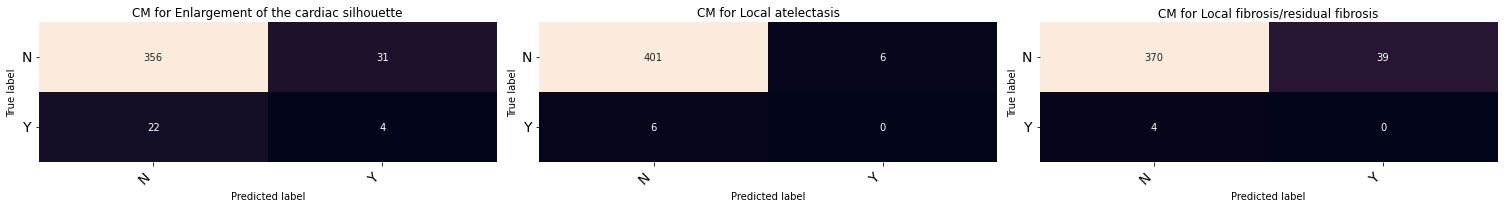

XGBoost
Hamming loss on test data: 0.322
Accuracy on test data: 0.029
ROC AUC on test data: 0.575
                                       precision    recall  f1-score   support

Enlargement of the cardiac silhouette      0.125     0.300     0.176        20
                    Local atelectasis      0.438     0.067     0.116       105
     Local fibrosis/residual fibrosis      0.250     0.148     0.186        54
                      Medical devices      0.812     0.527     0.639       131
            Parenchymal opacification      0.341     0.396     0.367       106
                     Pleural effusion      0.418     0.314     0.358       121
                         Pneumothorax      0.000     0.000     0.000       340

                            micro avg      0.430     0.194     0.267       877
                            macro avg      0.340     0.250     0.263       877
                         weighted avg      0.291     0.194     0.219       877
                          sampl

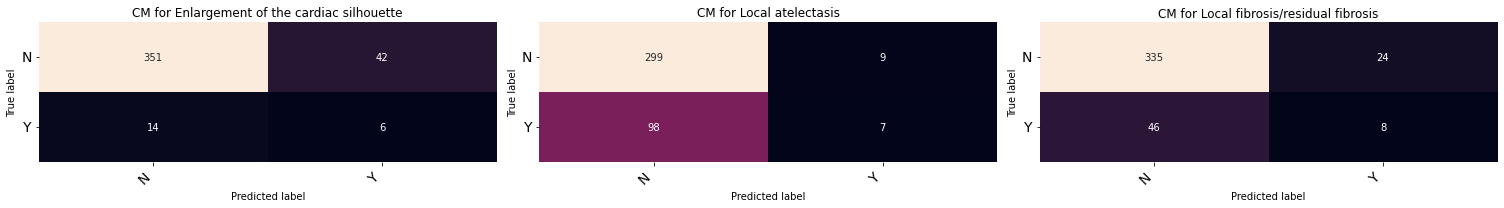

XGBoost
Hamming loss on test data: 0.322
Accuracy on test data: 0.029
ROC AUC on test data: 0.559
                                       precision    recall  f1-score   support

Enlargement of the cardiac silhouette      0.118     0.271     0.165        48
                    Local atelectasis      0.474     0.078     0.134       115
     Local fibrosis/residual fibrosis      0.714     0.091     0.161        55
                      Medical devices      0.768     0.768     0.768       112
            Parenchymal opacification      0.804     0.120     0.208       343
                     Pleural effusion      0.740     0.164     0.268       226
                         Pneumothorax      0.022     0.050     0.030        20

                            micro avg      0.486     0.209     0.292       919
                            macro avg      0.520     0.220     0.248       919
                         weighted avg      0.684     0.209     0.273       919
                          sampl

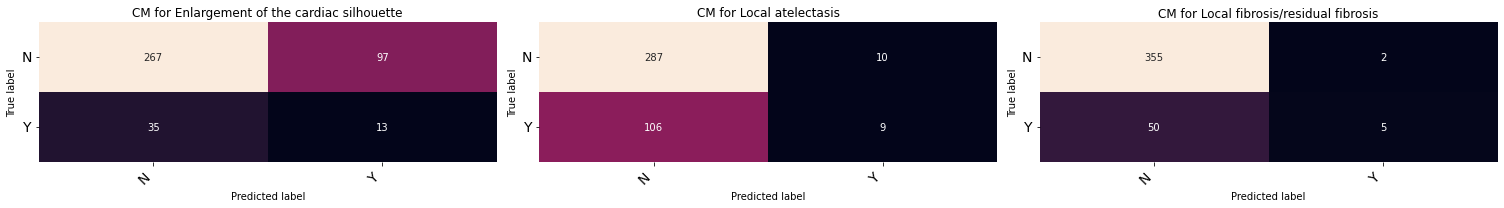

XGBoost
Hamming loss on test data: 0.311
Accuracy on test data: 0.027
ROC AUC on test data: 0.617
                                       precision    recall  f1-score   support

Enlargement of the cardiac silhouette      1.000     0.005     0.010       379
                    Local atelectasis      0.367     0.139     0.202        79
     Local fibrosis/residual fibrosis      0.083     0.019     0.030        54
                      Medical devices      0.863     0.620     0.721       142
            Parenchymal opacification      0.371     0.527     0.435       112
                     Pleural effusion      0.516     0.405     0.454       116
                         Pneumothorax      0.135     0.625     0.222         8

                            micro avg      0.492     0.239     0.322       890
                            macro avg      0.476     0.334     0.297       890
                         weighted avg      0.716     0.239     0.255       890
                          sampl

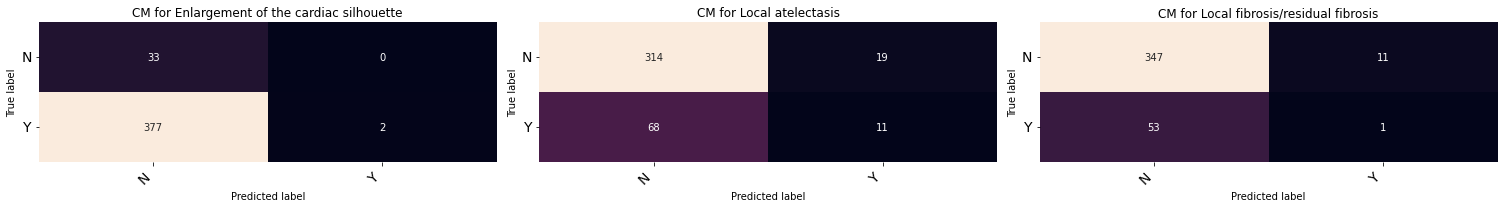

XGBoost
Hamming loss on test data: 0.229
Accuracy on test data: 0.194
ROC AUC on test data: 0.597
                                       precision    recall  f1-score   support

Enlargement of the cardiac silhouette      0.288     0.319     0.303        47
                    Local atelectasis      0.278     0.053     0.088        95
     Local fibrosis/residual fibrosis      0.583     0.045     0.084       154
                      Medical devices      0.824     0.500     0.622        56
            Parenchymal opacification      0.500     0.312     0.385        96
                     Pleural effusion      0.565     0.304     0.395       115
                         Pneumothorax      0.052     0.417     0.093        12

                            micro avg      0.374     0.217     0.275       575
                            macro avg      0.441     0.279     0.282       575
                         weighted avg      0.503     0.217     0.268       575
                          sampl

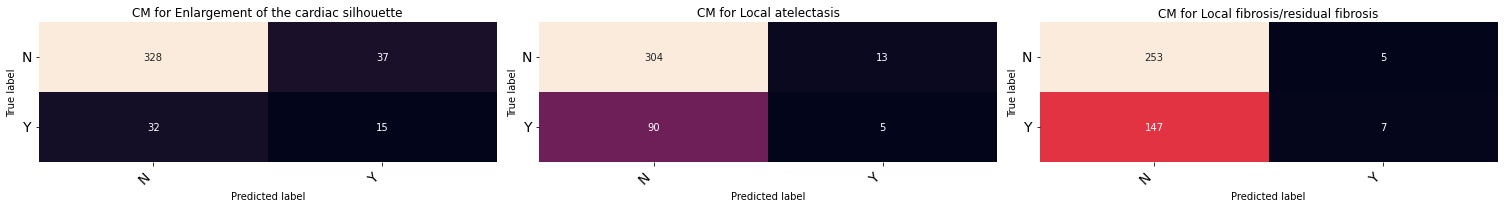

In [32]:
kf = KFold(n_splits=5)
xgb_estimator = xgb.XGBClassifier(objective='binary:logistic', n_jobs=8, seed=42)
xgb_estimator = MultiOutputClassifier(xgb_estimator)
ham_all, acc_all, rocauc_all, rep_all = [], [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.to_numpy()[train_index], X.to_numpy()[test_index]
    y_train, y_test = y.to_numpy()[train_index], y.to_numpy()[test_index]

    X_train=np.reshape(X_train, X_train.shape, order='C')
    X_train = np.ascontiguousarray(X_train)

    y_train=np.reshape(y_train, y_train.shape, order='C')
    y_train = np.ascontiguousarray(y_train)

    X_test=np.reshape(X_test, X_test.shape, order='C')
    X_test = np.ascontiguousarray(X_test)

    y_test=np.reshape(y_test, y_test.shape, order='C')
    y_test = np.ascontiguousarray(y_test)

    xgb_estimator.fit(X_train, y_train.astype('int'))
    joblib.dump(xgb_estimator, 'model_xgb_estimator.json')
    prediction2 = xgb_estimator.predict(X_test)
    ham, acc, rocauc, rep = evaluationutils.evaluate(y_test, prediction2, CLASSES_NAMES, 'XGBoost')
    
    ham_all.append(ham)
    acc_all.append(acc)
    rocauc_all.append(rocauc)
    rep_all.append(rep)

In [33]:
print('Hamming loss on test data: {:.3f}'.format(np.average(ham_all)))
print('Accuracy on test data: {:.3f}'.format(np.average(acc_all)))
print('ROC AUC on test data: {:.3f}'.format(np.average(rocauc_all)))

Hamming loss on test data: 0.255
Accuracy on test data: 0.153
ROC AUC on test data: 0.597


In [34]:
rep_all

[{'Enlargement of the cardiac silhouette': {'precision': 0.11428571428571428,
   'recall': 0.15384615384615385,
   'f1-score': 0.13114754098360656,
   'support': 26},
  'Local atelectasis': {'precision': 0.0,
   'recall': 0.0,
   'f1-score': 0.0,
   'support': 6},
  'Local fibrosis/residual fibrosis': {'precision': 0.0,
   'recall': 0.0,
   'f1-score': 0.0,
   'support': 4},
  'Medical devices': {'precision': 0.8571428571428571,
   'recall': 0.6666666666666666,
   'f1-score': 0.75,
   'support': 18},
  'Parenchymal opacification': {'precision': 0.05154639175257732,
   'recall': 1.0,
   'f1-score': 0.0980392156862745,
   'support': 5},
  'Pleural effusion': {'precision': 0.08695652173913043,
   'recall': 0.4,
   'f1-score': 0.14285714285714285,
   'support': 5},
  'Pneumothorax': {'precision': 0.17391304347826086,
   'recall': 0.25,
   'f1-score': 0.20512820512820512,
   'support': 16},
  'micro avg': {'precision': 0.11392405063291139,
   'recall': 0.3375,
   'f1-score': 0.1703470031545

In [35]:
def report_average(reports):
    mean_dict = dict()
    for label in reports[0].keys():
        dictionary = dict()

        if label in 'accuracy':
            mean_dict[label] = sum(d[label] for d in reports) / len(reports)
            continue

        for key in reports[0][label].keys():
            dictionary[key] = round(sum(d[label][key] for d in reports) / len(reports), 3)
        mean_dict[label] = dictionary

    return mean_dict

In [36]:
report_average(rep_all)

{'Enlargement of the cardiac silhouette': {'precision': 0.329,
  'recall': 0.21,
  'f1-score': 0.157,
  'support': 104.0},
 'Local atelectasis': {'precision': 0.311,
  'recall': 0.067,
  'f1-score': 0.108,
  'support': 80.0},
 'Local fibrosis/residual fibrosis': {'precision': 0.326,
  'recall': 0.061,
  'f1-score': 0.092,
  'support': 64.2},
 'Medical devices': {'precision': 0.825,
  'recall': 0.616,
  'f1-score': 0.7,
  'support': 91.8},
 'Parenchymal opacification': {'precision': 0.414,
  'recall': 0.471,
  'f1-score': 0.299,
  'support': 132.4},
 'Pleural effusion': {'precision': 0.465,
  'recall': 0.317,
  'f1-score': 0.324,
  'support': 116.6},
 'Pneumothorax': {'precision': 0.077,
  'recall': 0.268,
  'f1-score': 0.11,
  'support': 79.2},
 'micro avg': {'precision': 0.379,
  'recall': 0.239,
  'f1-score': 0.265,
  'support': 668.2},
 'macro avg': {'precision': 0.392,
  'recall': 0.287,
  'f1-score': 0.256,
  'support': 668.2},
 'weighted avg': {'precision': 0.494,
  'recall': 0.2